# Masked Autoencoders As Spatiotemporal Learners
This is a visualization demo showcasing a pre-trained MAE-3D model.

### Installation


In [ ]:
# Clone the repository and install dependencies
!git clone https://github.com/cyrilzakka/MAE3D
%cd MAE3D
!pip install -r requirements.txt

### Visualization

In [7]:
import torch
import numpy as np

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

import models_mae3d


IMAGENET_MEAN = np.array([0.485, 0.456, 0.406])
IMAGENET_STD = np.array([0.229, 0.224, 0.225])


def show_sequence(seq, title=''):
    '''Plot a sequence of images horizontally'''
    # clip is [T, H, W, 3]
    assert (seq.shape[-1] == 3) 
    fig = plt.figure(figsize=(20, 2.5))
    fig.suptitle(title, fontsize=16)
    grid = ImageGrid(fig, 111, nrows_ncols=(1, 8), axes_pad=0.1)
    for ax, img in zip(grid, seq):
        ax.imshow(torch.clip((img * IMAGENET_STD + IMAGENET_MEAN) * 255, 0, 255).int())
        ax.set_axis_off()
    plt.show()
    return

def prepare_model(chkpt_dir, arch='mae3d_vit_large_patch16'):
    '''Retrieve model from checkpoint'''
    # build model
    model = getattr(models_mae3d, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_sequence(seq, model):
    '''Run model on one video sequence'''
    x = torch.tensor(seq)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nthwc->ncthw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0.90)
    y = model.unpatchify3D(y)
    y = torch.einsum('ncthw->nthwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[1]**2 *3 *2)  # (N, H*W, p*p*3)
    mask = model.unpatchify3D(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('ncthw->nthwc', mask).detach().cpu()
    
    x = torch.einsum('ncthw->nthwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    show_sequence(x[0], "original")
    show_sequence(im_masked[0], "masked")
    show_sequence(y[0], "reconstruction")
    show_sequence(im_paste[0], "reconstruction + visible")

    plt.show()

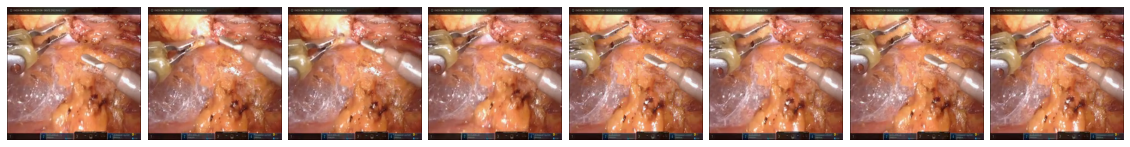

In [2]:
# Load images into sequence
import os
import torch
from PIL import Image
import numpy as np

path = "/home/cyril/Documents/images/"
images = os.listdir(path)
input = []
for img in images:
    if img.endswith(('.jpg', '.png', 'jpeg')):
        img_path = path + img
        image = Image.open(img_path)
        image = image.resize((224, 224))
        image = np.array(image) / 255.
        assert image.shape == (224, 224, 3)
        image = image - IMAGENET_MEAN
        image = image / IMAGENET_STD
        input.append(image)
input = np.stack(input, axis=0)
show_sequence(torch.tensor(input))

In [3]:
chkpt_dir = '/home/cyril/Documents/MAE3D-main/checkpoints/checkpoint-799_1x16.pth'
model_mae = prepare_model(chkpt_dir, 'mae3d_vit_base_patch16')
print('Model loaded.')

<All keys matched successfully>
Model loaded.


MAE with pixel reconstruction:


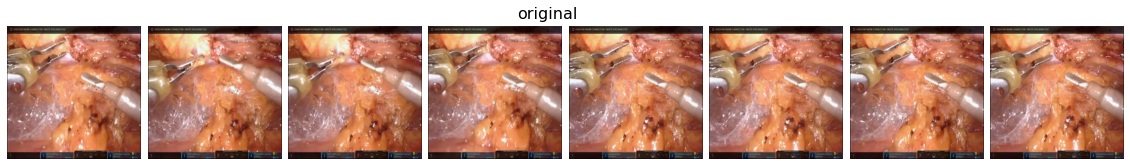

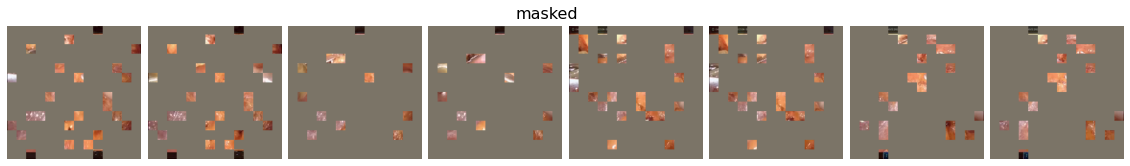

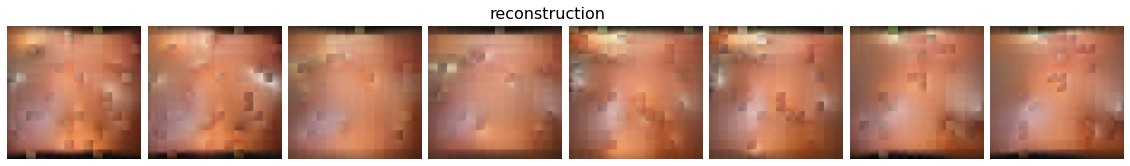

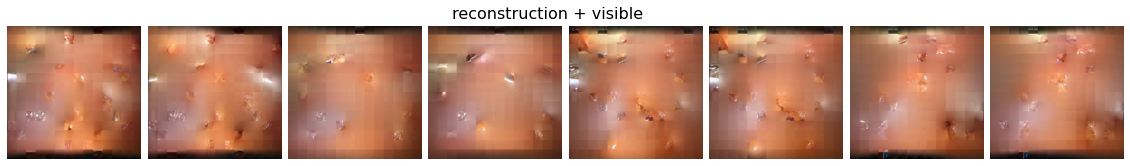

In [8]:
# make random mask reproducible (comment out to make it change)
torch.manual_seed(2)
print('MAE with pixel reconstruction:')
run_one_sequence(input, model_mae)